In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor

from torchvision import transforms, datasets, utils
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

import matplotlib.pyplot as plt
import numpy as np
import copy
import os

import warnings
warnings.filterwarnings('ignore')

In [37]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [38]:
DATA_PATH = '../data/stl-10'

train = datasets.STL10(DATA_PATH, split='train', download=True, transform=transforms.ToTensor())
test = datasets.STL10(DATA_PATH, split='test', download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [39]:
img, _ = train[1]
print(img.shape)
print(len(train), len(test))

torch.Size([3, 96, 96])
5000 8000


In [40]:
meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in train]
stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in train]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

train.transform = data_transform
test.transform = data_transform

print(train.data.shape, test.data.shape)

(5000, 3, 96, 96) (8000, 3, 96, 96)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


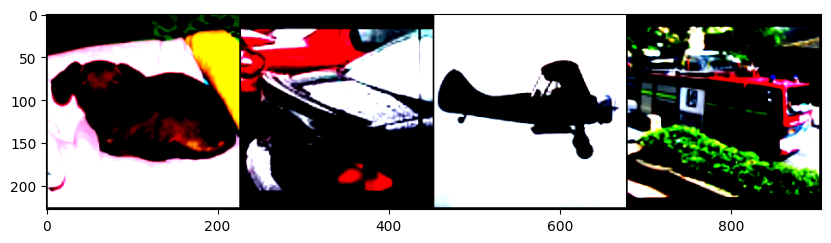

In [41]:
def show_img(img, y=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

np.random.seed(0)
torch.manual_seed(0)

random_idx = np.random.randint(0, len(train), 4)

x_grid = [train[i][0] for i in random_idx]
y_grid = [train[i][1] for i in random_idx]

x_grid = utils.make_grid(x_grid, nrow=4)
plt.figure(figsize=(10,10))
show_img(x_grid, y_grid)

In [42]:
train_loader = DataLoader(train, batch_size=16)
valid_loader = DataLoader(test, batch_size=32)

In [68]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, patch_size, stride = patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

x = torch.randn(16, 3, 224, 224).to(device)
patch_embedding = PatchEmbedding().to(device)
patch_output = patch_embedding(x)

print(patch_output.shape)

torch.Size([16, 197, 768])


In [70]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask=None):
        queries = rearrange(self.queries(x), 'b n (h d) -> b h n d',
                            h = self.num_heads)
        keys = rearrange(self.keys(x), 'b n (h d) -> b h n d',
                         h = self.num_heads)
        values = rearrange(self.values(x), 'b n (h d) -> b h n d',
                    h = self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (0.5)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out

MultiHeadAtt = MultiHeadAttention().to(device)
MHA_output = MultiHeadAtt(patch_output)
print(MHA_output.shape)

torch.Size([16, 197, 768])


In [71]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [72]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

x = torch.randn(16, 1, 128).to(device)
FFB_model = FeedForwardBlock(128).to(device)
FFB_output = FFB_model(x)
print(FFB_output.shape)

torch.Size([16, 1, 128])


In [73]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=768, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )

TEB_model = TransformerEncoderBlock().to(device)
TEB_output = TEB_model(patch_output).to(device)
print(TEB_output.shape)

torch.Size([16, 197, 768])


In [74]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

TE_model = TransformerEncoder().to(device)
TE_output = TE_model(patch_output)
print(TE_output.shape)

torch.Size([16, 197, 768])


In [75]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=768, n_classes=10):
        super().__init__(
            Reduce('b n e -> b e', reduction = 'mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

x = torch.randn(16, 1, 768).to(device)
CH_model = ClassificationHead().to(device)
CH_output = CH_model(x)
print(CH_output.shape)

torch.Size([16, 10])


In [76]:
class ViT(nn.Sequential):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=10, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

x = torch.randn(16, 3, 224, 224).to(device)
model = ViT().to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


In [77]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.01)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# ReduceLROnPlateau : When the metric does not change for patient epochs multiply factor to learning rate
    # mode = either 'min' or 'max', if 'min' When the metric stops decreasing change learning rate
    # factor = multiply factor to learning rate
    # patience = numbers of epochs that wait
    # threshold = standard value of 'metric stop changes'
    # cooldown = for initial cooldowns epochs, does not change learning rate
    # eps = minimum of learning rate
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [78]:
# calculate accuracy per batch
def get_accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# calculate loss per batch
def loss_batch(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    acc = get_accuracy(output, target)
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # loss.backward()
        optimizer.step()
    return loss.item(), acc

# calculate performance loss, accuracy per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, optimizer=None):
    running_loss = 0
    running_acc = 0
    len_data = float(len(dataset_dl.dataset))

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output_= model(xb)

        loss_b, acc_b = loss_batch(loss_func, output, yb, optimizer)
        running_loss += loss_b

        if acc_b is not None:
            running_acc += acc_b

        if sanity_check: # if sannity_check is True, only one batch is processed
            break

    loss = running_loss / len_data
    acc = running_acc / len_data
    return loss, acc

In [79]:
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': []
    }

    acc_history = {
        'train': [],
        'val': []
    }

    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_acc = loss_epoch(model, loss_func, train_dl, sanity_check, optimizer)
        loss_history['train'].append(train_loss)
        acc_history['train'].append(train_acc)

        model.eval()
        with torch.no_grad():
            val_loss, val_acc = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        acc_history['val'].append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step()
        # if current_lr != get_lr(optimizer):
        #     print('Loading best model weights!')
        #     model.load_state_dict(best_model_weights)

        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' % (train_loss, val_loss, val_acc*100))
        print('-'*15)

        if epoch % 1 == 0:
            model.load_state_dict(best_model_weights)

    return model, loss_history, acc_history

In [80]:
os.makedirs('./models', exist_ok=True)

params_train = {
    'num_epochs': 5, # 100
    'optimizer': optimizer,
    'loss_func': criterion,
    'train_dl': train_loader,
    'val_dl': valid_loader,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': './models/weights.pt'
}

model, loss_hist, acc_hist = train_val(model, params_train)

Epoch 0/2, current lr = 0.01



KeyboardInterrupt



In [ ]:
# just for tracking edu, meaningless plots

num_epochs = params_train['num_epochs']


plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train loss')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val loss')
plt.legend()
plt.show()

plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['train'], label='train accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['val'], label='val accuracy')
plt.legend()
plt.show()